<a href="https://colab.research.google.com/github/reveondivad/ExData_Plotting1/blob/master/GAN_Abstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract Art Generator
Data is here https://www.kaggle.com/bryanb/abstract-art-gallery

Code is here https://towardsdatascience.com/generating-abstract-art-using-gans-with-keras-153b7f11bd0

MNIST variety https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/


In [4]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from IPython.display import clear_output

upload abstract_art.zip to session folder
unzip

In [5]:
!unzip abstract_art.zip

Archive:  abstract_art.zip
  inflating: Abstract_gallery/Abstract_image_0.jpg  
  inflating: Abstract_gallery/Abstract_image_1.jpg  
  inflating: Abstract_gallery/Abstract_image_10.jpg  
  inflating: Abstract_gallery/Abstract_image_100.jpg  
  inflating: Abstract_gallery/Abstract_image_1000.jpg  
  inflating: Abstract_gallery/Abstract_image_1001.jpg  
  inflating: Abstract_gallery/Abstract_image_1002.jpg  
  inflating: Abstract_gallery/Abstract_image_1003.jpg  
  inflating: Abstract_gallery/Abstract_image_1004.jpg  
  inflating: Abstract_gallery/Abstract_image_1005.jpg  
  inflating: Abstract_gallery/Abstract_image_1006.jpg  
  inflating: Abstract_gallery/Abstract_image_1007.jpg  
  inflating: Abstract_gallery/Abstract_image_1008.jpg  
  inflating: Abstract_gallery/Abstract_image_1009.jpg  
  inflating: Abstract_gallery/Abstract_image_101.jpg  
  inflating: Abstract_gallery/Abstract_image_1010.jpg  
  inflating: Abstract_gallery/Abstract_image_1011.jpg  
  inflating: Abstract_gallery/A

In [6]:
import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(y/(1-y))
%matplotlib inline
path = 'Abstract_gallery'
os.getcwd()
img_list = os.listdir(path)
def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        img = Image.open(path+'/'+img_list[i],'r')
        basewidth = 100
        img = img.resize((basewidth,basewidth), Image.ANTIALIAS)
        pix = np.array(img.getdata())
        pixels.append(pix.reshape(100,100,3))
        imgs.append(img)
    return np.array(pixels),imgs
def show_image(pix_list):
    array = np.array(pix_list.reshape(100,100,3), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()
pixels,imgs = access_images(img_list,path,1000)
pixels.shape

(1000, 100, 100, 3)

# Define discriminator

In [7]:
def define_discriminator(in_shape = (100,100,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Define generator

In [8]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 25 * 25
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((25, 25, 128)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (7,7) , padding='same'))
    return model

# Define GAN

In [9]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Generator for Parts

In [10]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

# Training

change the n_epochs=100 here
or when training call

In [11]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    print(dataset.shape[0])
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

# Summarize performance

In [12]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# Start

In [13]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim)
print(pixels)

[[[[234 227 218]
   [201 175 155]
   [173 132 120]
   ...
   [228 215 196]
   [225 211 192]
   [226 211 189]]

  [[211 200 190]
   [221 202 180]
   [238 224 200]
   ...
   [228 213 190]
   [229 212 190]
   [227 210 189]]

  [[212 200 189]
   [213 192 167]
   [233 216 191]
   ...
   [231 218 199]
   [233 220 201]
   [228 214 191]]

  ...

  [[223 196 172]
   [233 215 193]
   [238 228 212]
   ...
   [238 225 203]
   [241 227 208]
   [237 224 204]]

  [[231 215 195]
   [236 225 208]
   [237 226 209]
   ...
   [235 221 202]
   [231 217 197]
   [236 224 204]]

  [[230 216 199]
   [230 215 197]
   [230 216 198]
   ...
   [195 171 157]
   [163 134 125]
   [222 205 186]]]


 [[[211 221 209]
   [213 223 213]
   [208 219 214]
   ...
   [217 231 209]
   [220 233 220]
   [198 199 188]]

  [[214 225 211]
   [218 229 213]
   [206 225 224]
   ...
   [219 232 216]
   [222 236 219]
   [205 207 190]]

  [[213 224 210]
   [218 227 218]
   [191 212 223]
   ...
   [221 233 214]
   [222 238 219]
   [207 210

In [14]:

# save the generator model tile file
#filename = 'generator_model_%03d.h5' % (epoch + 1)
#g_model.save(filename)

NameError: ignored

In [15]:

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()


TypeError: ignored

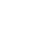

In [19]:
save_plot("",10)